In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import datetime
import matplotlib.cm as cm
import time
from sklearn.feature_selection import SelectKBest,f_regression,SelectFromModel,RFE
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from IPython.core.debugger import set_trace




# Load and cleaning data

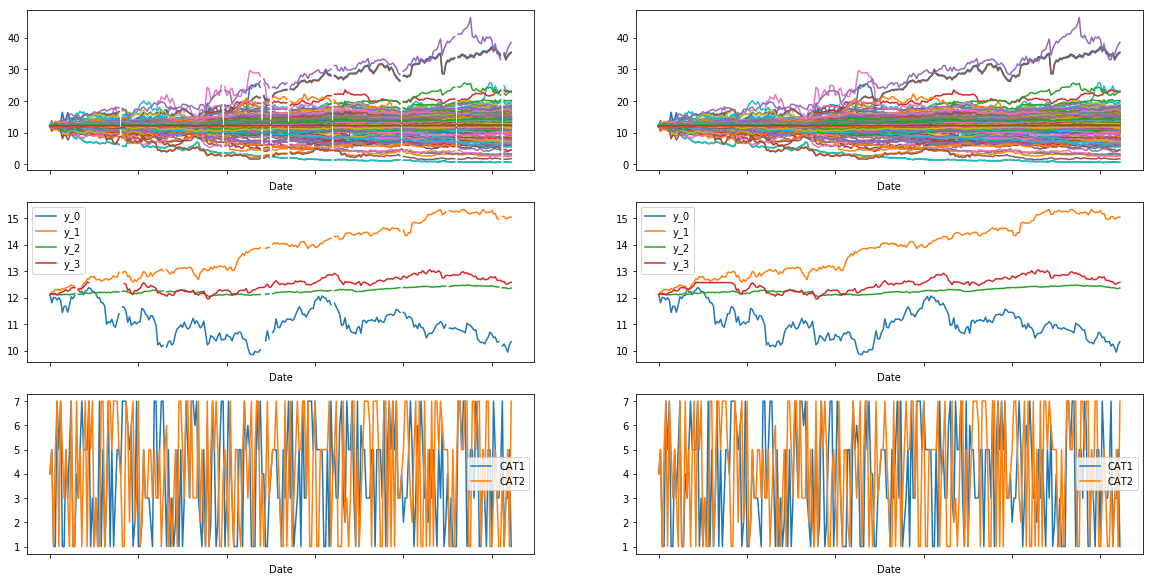


Shape of x after cleaning: (262, 444)


In [2]:
X = pd.read_csv('X.csv',index_col=0)
y = pd.read_csv('y.csv',index_col=0)
cat = pd.read_csv('categorical.csv',index_col=0)

#Visualize imported data and examine
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20,10))
X.plot(ax=axes[0,0],legend=False)
y.plot(ax=axes[1,0])
cat.plot(ax=axes[2,0])

#here we are using last observed data for missing values of stock prices
X.fillna(method='ffill', inplace=True)
y.fillna(method='ffill', inplace=True)
cat.fillna(method='ffill', inplace=True)

X.plot(ax=axes[0,1],legend=False)
y.plot(ax=axes[1,1])
cat.plot(ax=axes[2,1])
plt.show()

print('\nShape of x after cleaning:', X.shape)

## examine categorical

In [3]:
cat['CAT1'].value_counts()

5    68
1    60
7    51
3    50
2    12
4    11
6    10
Name: CAT1, dtype: int64

In [4]:
cat['CAT2'].value_counts()



7    76
1    67
5    59
3    37
4    10
2     8
6     5
Name: CAT2, dtype: int64

# preprocess routines

In [5]:
def identical_cat(I, cat):
    # sample from all dates with identical set of cat1 & cat2
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    newI = [(pd.Series(cat_group[tuple(cat.iloc[I[i],:])]).sample()).iloc[0] for i in range(len(I))]
    
    return newI

In [6]:
def drop_corr_in_x(x, cutoff=0.9):
    '''Drop highly correlated columns from dx. c is the cutoff correlation level. '''     
    # calculate the correlation matrix of dx, and take the upper triangular of the 
    # matrix in order to find columns to drop
    corr_x = np.triu(np.corrcoef(x, rowvar=False), k=1)    
    drop_ind = np.nonzero(corr_x>cutoff)
    x_d = x.drop(x.columns[drop_ind[1]], axis=1)     
    return x_d


(262, 161)
y_0, std=0.15, r2_train=0.94, r2_test=0.93 Selected features:  ['x_1', 'x_74', 'x_127', 'x_190', 'x_339'] with weights:  ['0.73', '0.09', '0.30', '0.25', '-0.21']
y_1, std=0.14, r2_train=0.98, r2_test=0.98 Selected features:  ['x_2', 'x_10', 'x_146', 'x_272', 'x_370'] with weights:  ['-0.12', '0.07', '0.05', '0.11', '0.06']
y_2, std=0.03, r2_train=0.95, r2_test=0.91 Selected features:  ['x_26', 'x_66', 'x_105', 'x_133', 'x_290'] with weights:  ['0.10', '0.02', '0.09', '-0.02', '0.03']
y_3, std=0.12, r2_train=0.83, r2_test=0.80 Selected features:  ['x_179', 'x_319', 'x_343', 'x_360', 'x_370'] with weights:  ['0.14', '-0.10', '0.41', '-0.13', '0.11']


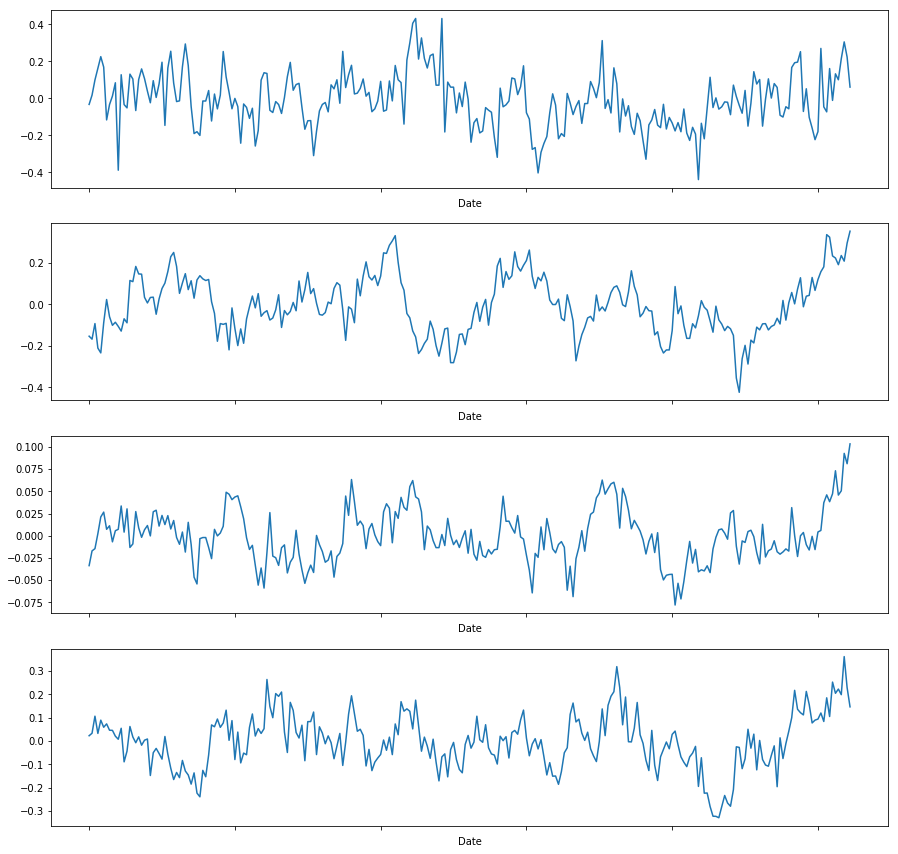

In [24]:
if __name__ == '__main__':
    
    n_best = 20
    n_limit = 5 #number of stocks used to hedge
    val_fold = 5 #inner cv for feature selection
    test_cv = 5 #outter cv for estimator performance evaluation
    
    X_d = drop_corr_in_x(X, cutoff=0.95)
    print(X_d.shape)
    
    #use the base estimator LassoCV since the L1 norm promotes sparsity of features.
    #use SelectFromModel to reduce the number of features to n_limit
    anova_filter = SelectKBest(f_regression, k=n_best)
    lassocv = linear_model.LassoCV(cv=val_fold)
    feature_selection = RFE(lassocv, n_features_to_select=n_limit) #SelectFromModel(lassocv)
    linreg = linear_model.LinearRegression()

    estimators = [('anova_filter', anova_filter), ('fs', feature_selection), ('regressor', linreg)]
    pipe = Pipeline(estimators)    
       
    fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(15,15))
    
    for column in y:
        kf = KFold(test_cv, shuffle=True)
        y_predict = pd.Series().reindex_like(y[column])
        score_in_val = []
        for train_index, test_index in kf.split(X_d):
            X_train, X_test = X_d.iloc[train_index], X_d.iloc[test_index]
            y_train, y_test = y[column].iloc[train_index], y[column].iloc[test_index]
            pipe.fit(X_train, y_train)
            y_predict[test_index] = pipe.predict(X_test) 
            s_train_fold = pipe.score(X_train, y_train)
            s_test_fold = pipe.score(X_test, y_test)
        
        s_train = s_train_fold.mean()
        s_test = s_test_fold.mean()
        pos=y_predict-y[column]
        
        af_features = X_train.columns[pipe.named_steps['anova_filter'].get_support()]
        fs_features = af_features[pipe.named_steps['fs'].get_support()]
        weights = pipe.named_steps['regressor'].coef_
        print("%s, std=%0.2f, r2_train=%.2f, r2_test=%.2f"%(column, pos.std(), s_train, s_test), 
              "Selected features: ",list(fs_features),
              "with weights: ",["{0:0.2f}".format(i) for i in weights])        
        
        pos.plot(ax=ax[y.columns.get_loc(column)])        
    plt.show()